In [1]:
# libraries
import os
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import util_functions as ut
import config as conf
import pickle
import pandas as pd
import geopandas as gpd
import math
from shapely import wkt, geometry
from supernetwork import Supernetwork

Read successful


In [2]:
#%% read pickled supernetwork (which includes unimodal networks joined by transfer edges)
cwd = os.getcwd()
with open(os.path.join(cwd, 'Data', 'Output_Data', 'G_super_od.pkl'), 'rb') as inp:
    G_super_od = pickle.load(inp)

inv_nid_map = dict(zip(G_super_od.nid_map.values(), G_super_od.nid_map.keys()))   # also adjust the inverse nidmap
#%%
# choose all neighborhoods for visualization
cwd = os.getcwd()
path = os.path.join(cwd, 'Data', 'Input_Data', 'Neighborhoods', "Neighborhoods_.shp")
nhoods = gpd.read_file(path)  # all neighborhoods

hood = conf.config_data['Geography']['neighborhoods']
hood_gdf = nhoods[nhoods['hood'].isin(hood)]  
                           

df = pd.DataFrame.from_dict(dict(G_super_od.graph.nodes), orient="index").reset_index()
#gdf_pt = gpd.GeoDataFrame(data=df, geometry=df.pos)
df[['x','y']] = pd.DataFrame(df.pos.tolist())
gdf_nodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y))
gdf_nodes.set_crs(epsg='4326', inplace=True)

# go back to the original PT graph, only keep nodes edges that are within the selected neighborhood
# 1) Nodes
G = nx.DiGraph()
node_dict = gdf_nodes.to_dict(orient='index')
G.add_nodes_from(node_dict.keys())
nx.set_node_attributes(G, node_dict)
# 2) Edges
df_edges = nx.to_pandas_edgelist(G_super_od.graph)
df_edges_keep = df_edges.loc[(df_edges['source'].isin(list(G.nodes))) & (df_edges['target'].isin(list(G.nodes)))]
df_edges_keep.set_index(['source','target'], inplace=True)
edge_dict = df_edges_keep.to_dict(orient='index')
G.add_edges_from(edge_dict.keys())
nx.set_edge_attributes(G, edge_dict)

#%% **for visualization**: jitter the graphs and draw
def jitter_nodes(G, network_type, jitter_param):
    #G_adj = G.copy()
    #print(G.nodes) #[node]['pos'])
    # adjust the nodes positions in the copy 
    nodes = [n for n in G.nodes.keys() if n not in ['org','dst'] if G.nodes[n]['nwk_type'] == network_type] 
    for n in nodes:
        adj_x = G.nodes[n]['pos'][0] + jitter_param
        adj_y = G.nodes[n]['pos'][1] + jitter_param
        nx.set_node_attributes(G, {n: {'pos_adj':(adj_x, adj_y)}})

#%%
# adjust the graphs in the supernetwork using the jitter function
# this is strictly for plotting
# for j, m in enumerate(modes_included):
#     print(j,m)
#     #if m != 't':  # tnc graph is the "base" road network so it will not be adjusted
#     G_adj = all_graphs_dict[m].copy()
#     jitter_nodes(G_adj, jitter_param=(j/100)*2)
#     adjusted_graph_dict[m] = G_adj

modes_included = conf.config_data['Supernetwork']['modes_included']
modes_included.remove('pt')
modes_included.insert(math.floor(len(modes_included)/2), 'pt')  # explicitly have PT graph be the one in the center

inv_nid_map = dict(zip(G_super_od.nid_map.values(), G_super_od.nid_map.keys()))   # also adjust the inverse nidmap

# previously j/200
jitter_param_dict = {m: (j/50)*2 for j,m in enumerate(modes_included)}  # can adjust jitter param as necessary



/home/lgraff/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgraff/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [15]:
# explicitly adjust org and dest if they are in the node list
G.nodes[inv_nid_map['org']]['pos_adj'] = (G.nodes[inv_nid_map['org']]['pos'][0] + 0.1*jitter_param_dict['pt'], 
                                          G.nodes[inv_nid_map['org']]['pos'][1] + 0.6*jitter_param_dict['pt']) 
G.nodes[inv_nid_map['dst']]['pos_adj'] = (G.nodes[inv_nid_map['dst']]['pos'][0] + 0.2*jitter_param_dict['pt'], 
                                          G.nodes[inv_nid_map['dst']]['pos'][1] + 0.8*jitter_param_dict['pt']) 


In [16]:
nid_map = G_super_od.nid_map
nid_map[7789] = 'org'
nid_map[7790] = 'dst'

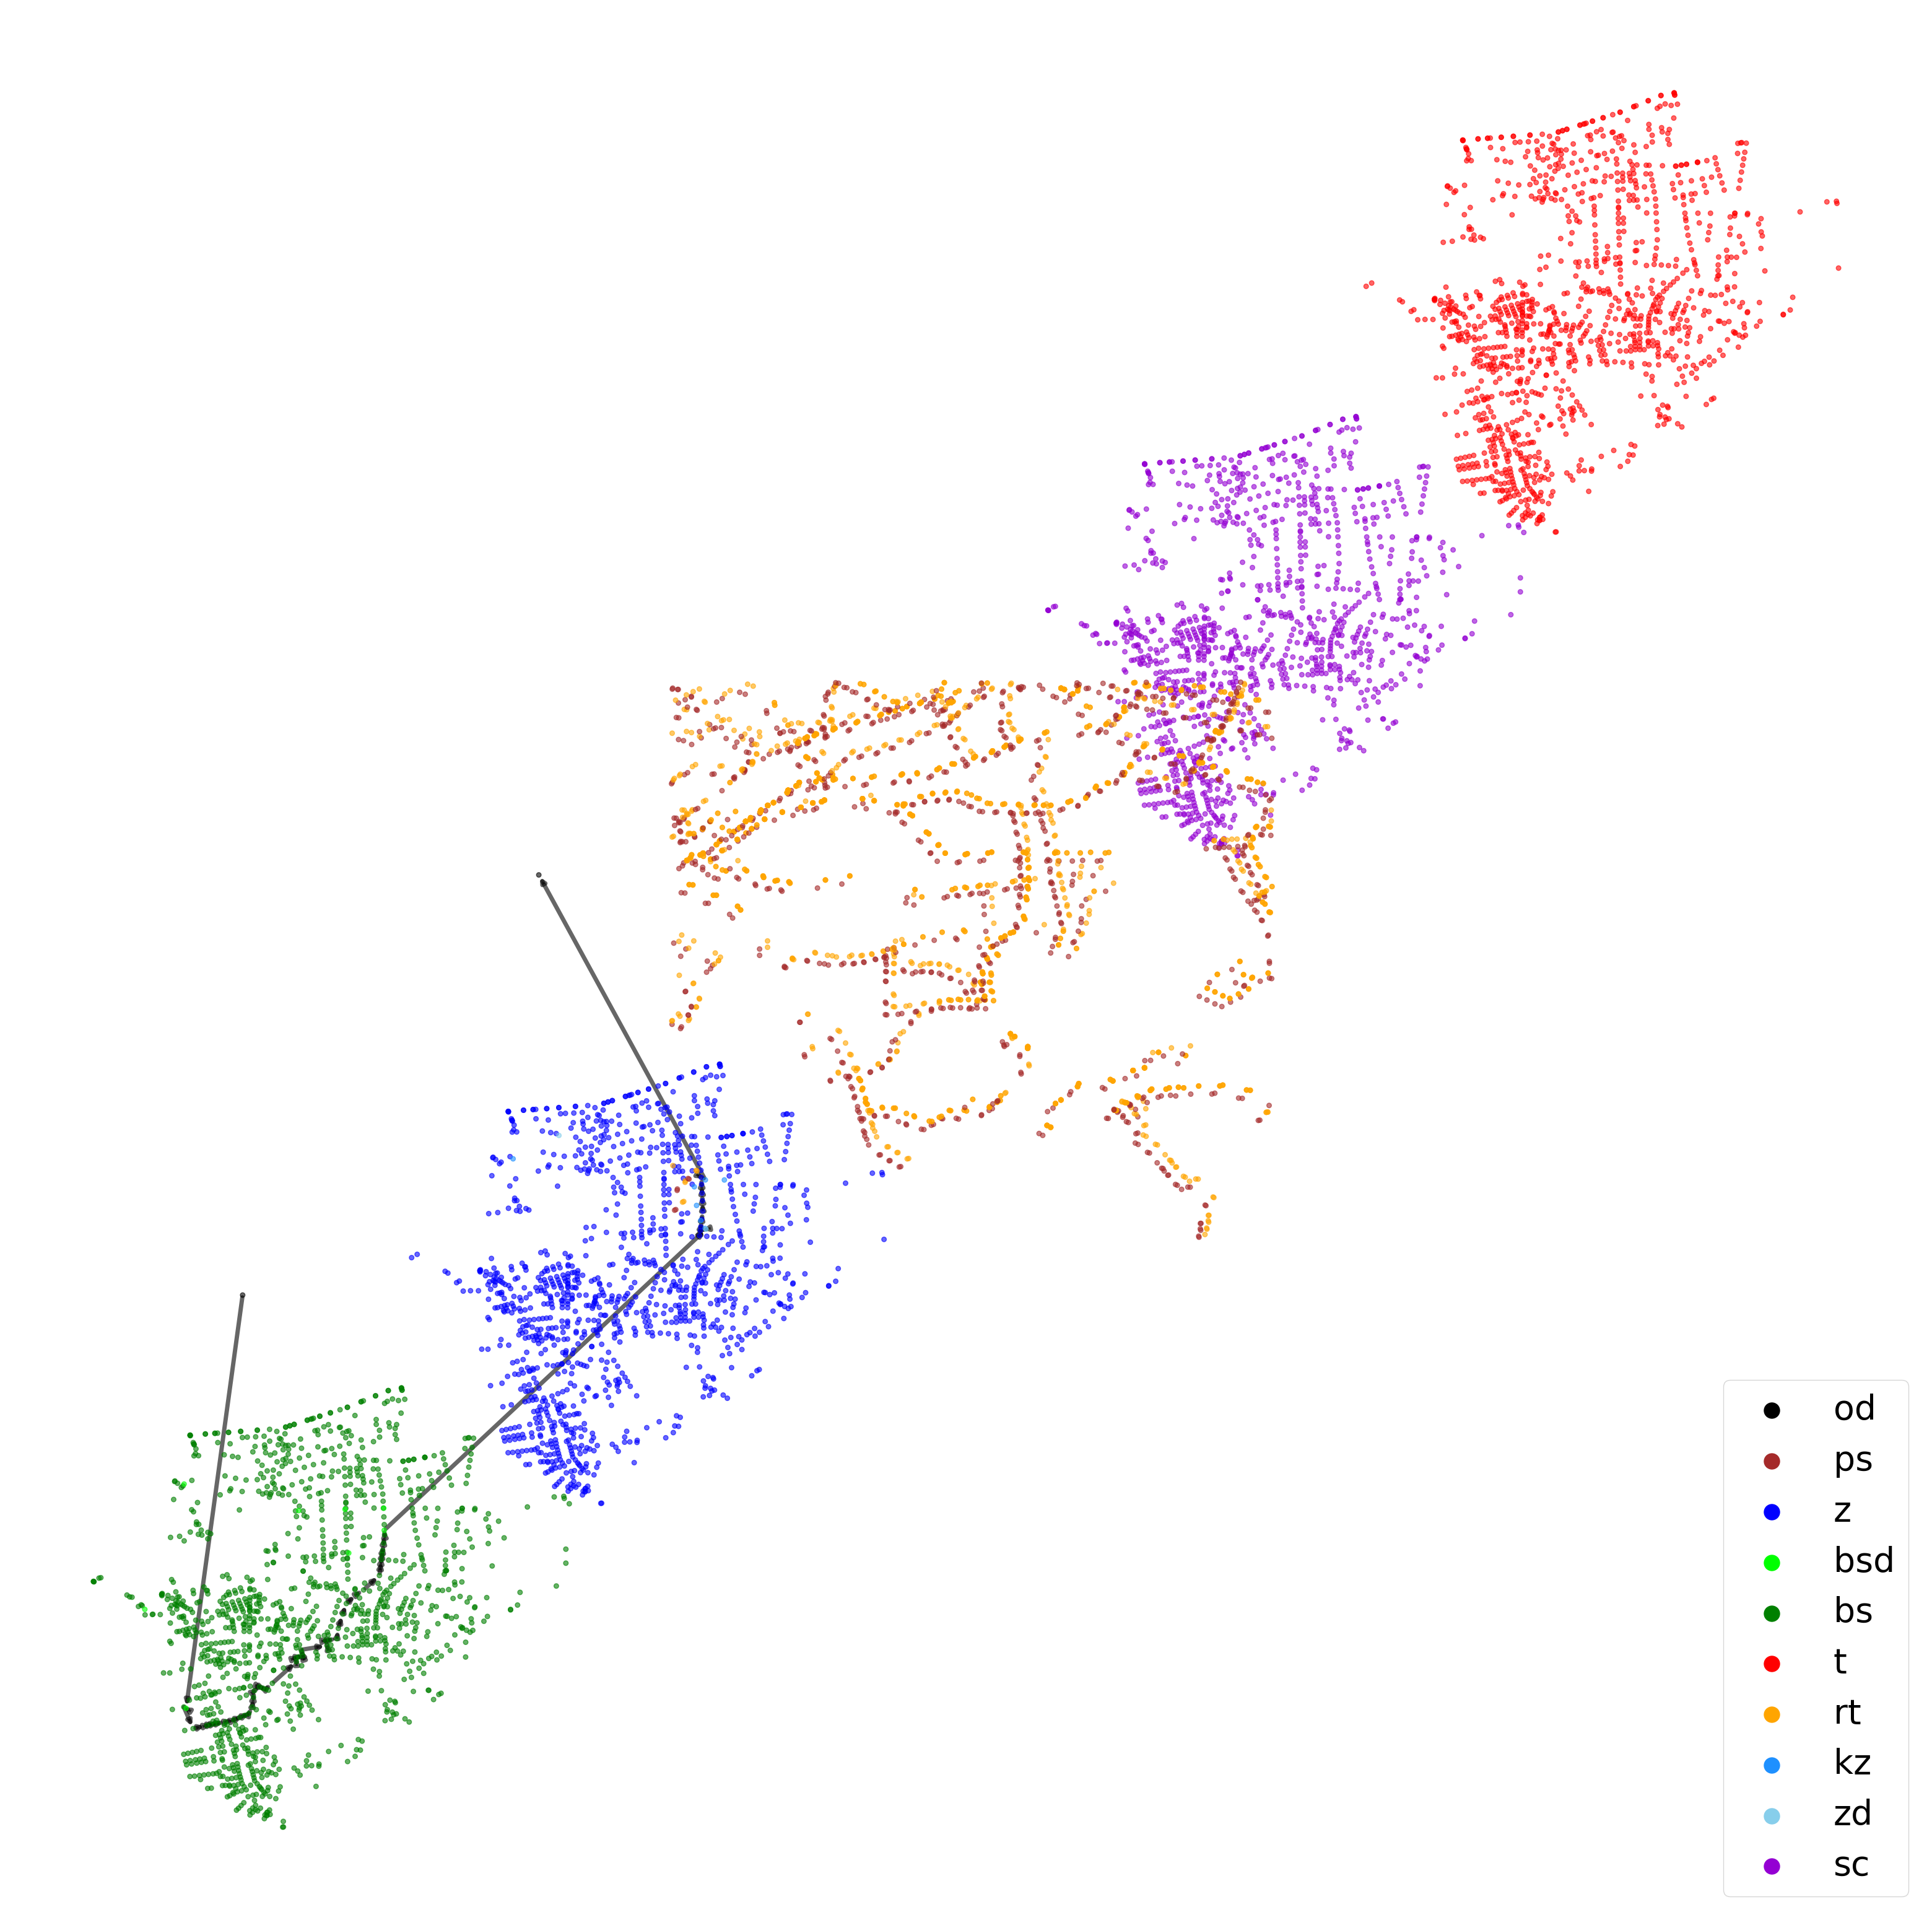

In [17]:
sp_nodes = list(np.genfromtxt(os.path.join(cwd,'shortest_path_ex2')).astype('int'))
sp_edges = list(zip(sp_nodes[:-1], sp_nodes[1:]))

for m in modes_included:
    jitter_nodes(G, m, jitter_param_dict[m])

# draw the graph in networkx
node_color_map = {'bs':'green', 'bsd':'lime', 'z':'blue', 'zd': 'skyblue', 'kz': 'dodgerblue',
                  'sc':'darkviolet', 't':'red', 'ps':'brown', 'rt': 'orange' , 'od':'black'}
node_color = [node_color_map[G.nodes[n]['node_type']] for n in G.nodes.keys()]
edge_color = ['darkgray' if G.edges[e]['mode_type'] == 'w' else 'black' for e in G.edges] 

edge_style = ['dotted' if G_super_od.graph.edges[nid_map[e[0]], nid_map[e[1]]]['mode_type'] == 'w' 
               else 'solid' for e in sp_edges]

pos = 'pos_adj'
node_coords = nx.get_node_attributes(G, pos)    
fig, ax = plt.subplots(figsize=(40,40))
nx.draw(G, pos=node_coords, node_color=node_color, node_size=30, alpha=0.6,
        edgelist=sp_edges, edge_color='black', width=5, ax=ax)
    
#nx.draw_networkx_nodes(G, pos=node_coords, node_color=node_color, node_size=30, alpha=0.6, ax=ax)
#nx.draw_networkx_edges(G, pos=node_coords, edgelist=sp_edges, edge_color='black', width=5, ax=ax)
# add legend for node color    
inv_node_cmap = dict(zip(node_color_map.values(), node_color_map.keys()))
for v in set(inv_node_cmap.keys()):
    ax.scatter([],[], c=v, label=inv_node_cmap[v])
ax.legend(loc = 'lower right', fontsize=40, markerscale=3)

In [18]:

# also include adjusted pos for org/dst
#G.nodes['org']['pos_adj'] = G.nodes['org']['pos']
#G.nodes['dst']['pos_adj'] = G.nodes['dst']['pos']


plt.savefig(os.path.join(cwd, 'images', 'graph_sp_ex2.png'), format='PNG')
#%%
#nx.draw_networkx_edges(G, pos=node_coords, edge_color=edge_color, style=edge_style, alpha=0.6, arrowsize=10, ax=ax)



#nx.draw(G, pos=node_coords, with_labels=False, font_color='white',  font_weight = 'bold',
 #       node_size=15, node_color=node_color, edge_color=edge_color, alpha=0.7, arrowsize=10, style=edge_style, ax=ax)


<Figure size 640x480 with 0 Axes>